In [28]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np
import time

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Experiment results for all 6 features (precip is removed)
# Added GP model

In [4]:
train_data = pd.read_csv('Data\processed_ab_no_precp_train.txt')
test_data = pd.read_csv('Data\processed_ab_no_precp_test.txt')

C:\Users\PPL\AppData\Local\Temp\ipykernel_78440\2297967146.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('Data\processed_ab_no_precp_train.txt')
C:\Users\PPL\AppData\Local\Temp\ipykernel_78440\2297967146.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('Data\processed_ab_no_precp_test.txt')


In [22]:
train_data

,longitude,latitude,name,id,date,temp,wind_direction,wind_speed
0,-112.82,53.05,CAMROSE,3011240,2012-07-09 17:00,31.8,23.0,11.0
1,-112.82,53.05,CAMROSE,3011240,2012-07-09 18:00,31.2,28.0,6.0
2,-112.82,53.05,CAMROSE,3011240,2012-07-09 19:00,30.1,6.0,6.0
3,-112.82,53.05,CAMROSE,3011240,2012-07-10 10:00,26.6,27.0,19.0
4,-112.82,53.05,CAMROSE,3011240,2012-07-10 11:00,26.1,28.0,19.0
...,...,...,...,...,...,...,...,...
534295,-115.55,51.19,BANFF CS,3050519,2023-09-14 06:00,1.9,21.0,4.0
534296,-115.55,51.19,BANFF CS,3050519,2023-09-14 07:00,1.4,3.0,1.0
534297,-115.55,51.19,BANFF CS,3050519,2023-09-14 18:00,18.4,24.0,7.0
534298,-115.55,51.19,BANFF CS,3050519,2023-09-14 19:00,13.7,23.0,3.0


In [8]:
plt.rcParams.update({'font.size': 16})

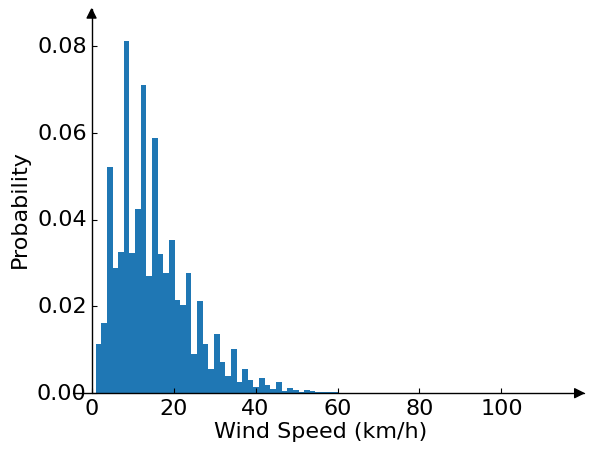

In [27]:
from mpl_toolkits.axisartist.axislines import SubplotZero

fig = plt.figure()
ax = SubplotZero(fig, 111)
fig.add_subplot(ax)

plt.hist(train_data['wind_speed'], bins=80, density=True)
for direction in ["xzero", "yzero"]:
    # adds arrows at the ends of each axis
    ax.axis[direction].set_axisline_style("-|>")

    # adds X and Y-axis from the origin
    ax.axis[direction].set_visible(True)

for direction in ["left", "right", "bottom", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)

plt.ylabel('Probability')
plt.xlabel('Wind Speed (km/h)')
plt.show()

In [43]:
def subsample_data(data, sample_size = 10000):
    indices = np.random.choice(data.shape[0], sample_size, replace=False)
    
    return indices

# Source: From the TSmodel
def preprocess_data(train_x, test_x, train_y, test_y):
    feature_scaler = StandardScaler()
    scaled_train_x = feature_scaler.fit_transform(train_x)
    scaled_test_x = feature_scaler.transform(test_x)

    target_scaler = StandardScaler()  
    scaled_train_y = target_scaler.fit_transform(train_y)
    scaled_test_y = target_scaler.transform(test_y)    
    
    return scaled_train_x, scaled_test_x, scaled_train_y, scaled_test_y, feature_scaler, target_scaler    

In [42]:
df.shape

(534300, 1)

In [67]:
# Modified from source: Dr.E Dr.Cui's private code 

# Kernel function, RBF + constant
# a is 2*sigma_f^2 as a single hyperparameter
def rbf_kernel(x1, x2, length_scale, a, c=1):
    """RBF kernel computation."""
    dist_sq = cdist(x1, x2)**2
    return a * np.exp(-dist_sq / (2 * length_scale**2)) + c

# log-likelihood estimation
def neg_log_likelihood(params, train_x, train_y, noise):
    """Compute the negative log likelihood for Gaussian process."""
    ls, a, c = params
    K = rbf_kernel(train_x, train_x, ls, a, c=c) + noise**2 * np.eye(len(train_x))
    try:
        L = np.linalg.cholesky(K)
        log_det = 2 * np.sum(np.log(np.diagonal(L)))
        inv_y = np.linalg.solve(L.T, np.linalg.solve(L, train_y))
        return 0.5 * np.dot(train_y.reshape(-1, train_y.shape[0])[0], inv_y.reshape(-1, train_y.shape[0])[0]) + 0.5 * log_det + 0.5 * len(train_x) * np.log(2 * np.pi)
    except np.linalg.LinAlgError:
        # In case the kernel matrix is not positive definite
        return np.inf

def gpr_model(train_x, train_y, test_x , test_y):
    indices = subsample_data(train_x, sample_size = 2000)
    
    sub_train_x = train_x[indices]
    sub_train_y = train_y[indices]

    gp_x, gp_x_test, gp_y, gp_y_test, feature_scaler, target_scaler = preprocess_data(sub_train_x, test_x, sub_train_y, test_y)

    
    # A small number to ensure non-sparse matrix is invertible
    alpha = 1e-10

    # Initial hyperparameters
    initial_ls = 1
    initial_a = 1
    initial_c = 1

    # Optimization
    result = minimize(neg_log_likelihood, 
                      [initial_ls, initial_a, initial_c], 
                      args=(gp_x, gp_y, 0.0), 
                      method='L-BFGS-B', 
                      bounds=[(1e-5, None), (1e-5, None), (1e-5, None)]
                      )
    # Optimized hyperparameters
    optimized_ls, optimized_a, optimized_c = result.x

    # Compute the RMSE for prediction
    gp_rmse = []
    for row_index in range(0, gp_x_test.shape[0], 1000):
        # specify a GP prior over the latent noise-free function
        cov = rbf_kernel(gp_x_test[row_index:row_index+1000, :], gp_x_test[row_index:row_index+1000, :], optimized_ls, optimized_a, optimized_c)

        #  let’s make predictions with these hypers (ls a)
        K_x_xstar = rbf_kernel(gp_x, gp_x_test[row_index:row_index+1000, :], optimized_ls, optimized_a, optimized_c)
                
        K_x_x = rbf_kernel(gp_x, gp_x, optimized_ls, optimized_a, optimized_c) + alpha*np.random.rand(gp_x.shape[0], gp_x.shape[0])
        K_xstar_xstar = cov

        post_mean = K_x_xstar.T @ np.linalg.inv((K_x_x)) @ gp_y
        #post_cov = K_xstar_xstar - K_x_xstar.T @ np.linalg.inv((K_x_x)) @ K_x_xstar

        # Calculate the upper and lower bound for 95% confidence interval, revert the normalization
        #lw_bd =  target_scaler.inverse_transform(post_mean - (np.sqrt(np.diag(post_cov))*2).reshape(-1, 1))
        #up_bd =  target_scaler.inverse_transform(post_mean + (np.sqrt(np.diag(post_cov))*2).reshape(-1, 1))
        
        rmse = np.mean(np.sqrt((target_scaler.inverse_transform(post_mean) - target_scaler.inverse_transform(gp_y_test[row_index:row_index+1000, :]))**2))
        gp_rmse.append(rmse)
    
    print("Root Mean Squared Error:", np.mean(gp_rmse))
    
    return np.mean(gp_rmse)

In [109]:
# Save the current experiment result and resume when needed
# Modified from source: https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later

# %store training_results
# %store training_times
# %store test_results
# %store nn_histories
# %store gpr_test_results

#closing seesion, restarting kernel

# %store -r training_results
# %store -r training_times
# %store -r test_results
# %store -r nn_histories
# %store -r gpr_test_results

Stored 'gpr_test_results' (list)


In [99]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [15] #[1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15,20]

# Expeirment related parameters
number_of_folds = 1 # have to be 10 fold

# Results containers for GP only, other models are saved
# GPR is a interpolation method, no need to record traning data.
gpr_test_results_opt = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):    
    for hyperparameter_value in hyper_parameter_to_test_values:
        
        # Station data is generated already, only need to train the model
        flatten_train_x = pd.read_csv(f"Data/exp/{hyperparameter_value}x.csv", index_col=0).to_numpy()
        # Select the wind speed only
        flatten_train_y = pd.read_csv(f"Data/exp/{hyperparameter_value}y.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)
        
        flatten_test_x = pd.read_csv(f"Data/exp/{hyperparameter_value}x_test.csv", index_col=0).to_numpy()
        # Select the wind speed only
        flatten_test_y = pd.read_csv(f"Data/exp/{hyperparameter_value}y_test.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)
        
        test_results_fold = []
        
        for i in range(1, 11):
            flatten_train_x, flatten_train_y = shuffle(flatten_train_x, flatten_train_y)
            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")
        
            # GP model
            gp_test_rmse = gpr_model(flatten_train_x, flatten_train_y, flatten_test_x , flatten_test_y)
            test_results_fold.append({'gpr_test' : gp_test_rmse})
            
            #After all folds are done, update the result containers
            gpr_test_results_opt.append(test_results_fold)
        

In [100]:
do_experiment(number_of_neighbour_stations)

Currently running fold 1 for 15 stations
Root Mean Squared Error: 5.3775514440408845
Currently running fold 2 for 15 stations
Root Mean Squared Error: 5.446657449663691
Currently running fold 3 for 15 stations
Root Mean Squared Error: 5.399530772985492
Currently running fold 4 for 15 stations
Root Mean Squared Error: 5.369642695412797
Currently running fold 5 for 15 stations
Root Mean Squared Error: 5.436332275249512
Currently running fold 6 for 15 stations
Root Mean Squared Error: 5.445705070064818
Currently running fold 7 for 15 stations
Root Mean Squared Error: 5.402758601012169
Currently running fold 8 for 15 stations
Root Mean Squared Error: 5.440504265601528
Currently running fold 9 for 15 stations
Root Mean Squared Error: 5.402550300041246
Currently running fold 10 for 15 stations
Root Mean Squared Error: 5.392143434196037


In [79]:
gpr_test_results[0:11]

[[{'gpr_test': 5201.790242401738}],
 [{'gpr_test': 21416.696883736742}],
 [{'gpr_test': 4839.597905786562}],
 [{'gpr_test': 6.281545263871523}],
 [{'gpr_test': 6.08222981434917}],
 [{'gpr_test': 5.994020210928746}],
 [{'gpr_test': 5.8339164538228205}],
 [{'gpr_test': 5.777788564979598}],
 [{'gpr_test': 5.716993201497576}],
 [{'gpr_test': 5.650317877303257}],
 [{'gpr_test': 5.623160592080015}]]

exp
7.2311±0.0
6.7706±0.015
6.2463±0.0068
exp
7.0071±0.0
6.7166±0.0
5.8777±0.0068
exp
6.9039±0.0
6.1219±0.0262
5.6055±0.0053
exp
6.6041±0.0
6.6041±0.0
5.5082±0.0067
exp
6.4277±0.0
6.4277±0.0
5.4781±0.0045
exp
6.4203±0.0
6.4203±0.0
5.4465±0.0047
exp
6.456±0.0
6.456±0.0
5.4597±0.0055
exp
6.5277±0.0
6.5277±0.0
5.446±0.0046
exp
6.452±0.0
6.452±0.0
5.4436±0.0054
exp
6.4835±0.0
6.4834±0.0
5.6134±0.4956
exp
6.5401±0.0
6.54±0.0
5.454±0.0081
exp
6.5716±0.0001
6.5715±0.0
5.4622±0.0114


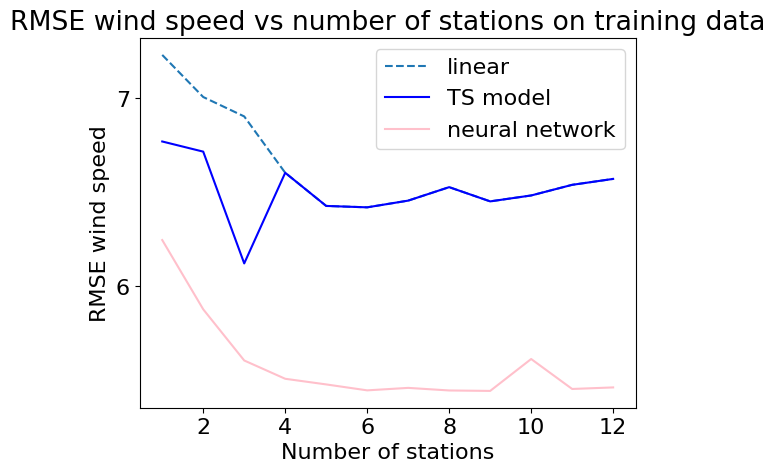

In [110]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10, 11, 12]
for exp in training_results:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7202)
# fcm_train_plot.insert(1, 6.6459)
# nn_train_plot.insert(1, 5.8963)

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper right")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on training data')

for exp in training_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]), 4)}±{np.round(np.std([d['linear_train'] for d in exp if 'linear_train' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]), 4)}±{np.round(np.std([d['nn_train'] for d in exp if 'nn_train' in d]),4)}")


exp
7.2407±0.0
6.7804±0.0128
6.235±0.0081
exp
7.0117±0.0
6.7255±0.0
5.8649±0.0073
exp
6.916±0.0
6.1403±0.0276
5.5969±0.0055
exp
6.6074±0.0
6.6074±0.0
5.5032±0.0077
exp
6.4329±0.0
6.4329±0.0
5.4698±0.0053
exp
6.4353±0.0
6.4353±0.0
5.4486±0.0058
exp
6.4589±0.0
6.4589±0.0
5.4641±0.0054
exp
6.5369±0.0
6.5368±0.0
5.4522±0.0037
exp
6.4553±0.0
6.4552±0.0
5.4465±0.0048
exp
6.4915±0.0
6.4915±0.0
5.6232±0.5039
exp
6.5555±0.0001
6.5554±0.0
5.4636±0.0075
exp
6.5839±0.0001
6.5838±0.0
5.4686±0.0078


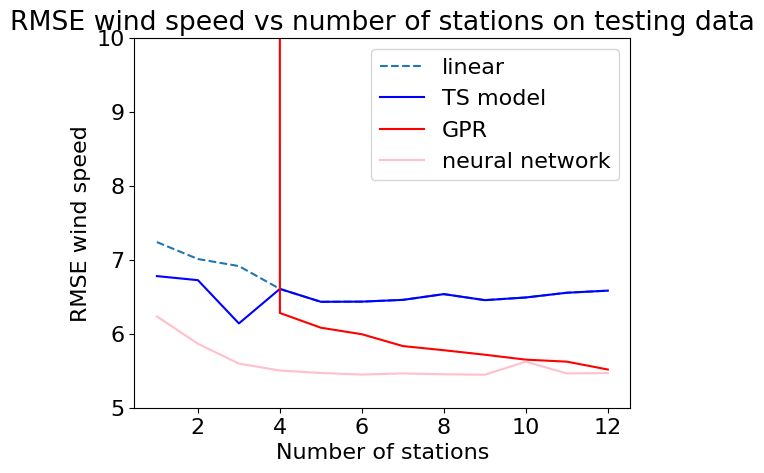

In [89]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_test_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10, 11, 12]
for exp in test_results:
    li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
    fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
    nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))

for exp in gpr_test_results[0:12]:
    gpr_test_plot.append(np.mean([d['gpr_test'] for d in exp if 'gpr_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7219)
# fcm_train_plot.insert(1, 6.6489)
# nn_train_plot.insert(1, 5.9011)


plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, gpr_test_plot, label='GPR', c='red')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper right")
plt.ylim(5,10)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on testing data')

for exp in test_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")


nan±nan


e:\Users\PPL\anaconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\Users\PPL\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
e:\Users\PPL\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
e:\Users\PPL\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
e:\Users\PPL\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


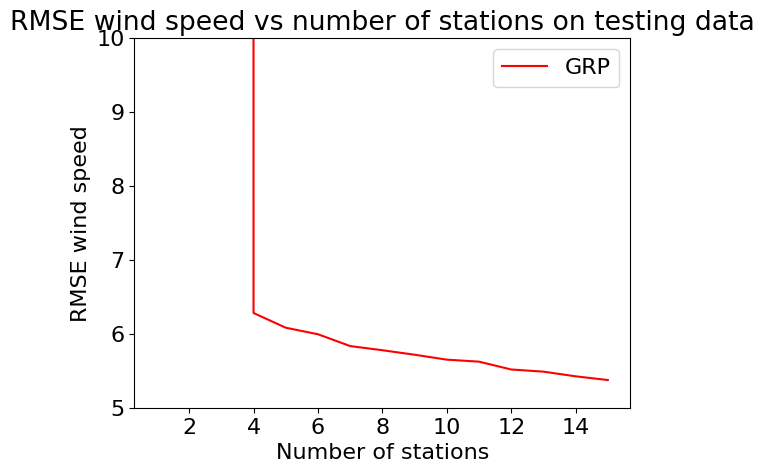

In [101]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_test_plot = []

x_axis = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15]
for exp in gpr_test_results:
    gpr_test_plot.append(np.mean([d['gpr_test'] for d in exp if 'gpr_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7219)
# fcm_train_plot.insert(1, 6.6489)
# nn_train_plot.insert(1, 5.9011)


plt.plot(x_axis, gpr_test_plot, label='GRP', c='red')
plt.legend(loc="upper right")
plt.ylim(5,10)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on testing data')





In [108]:
result = []
for arr in gpr_test_results_opt:
    for d in arr:
        result.append(d['gpr_test'])

print(f"{np.round(np.mean(result), 4)}±{np.round(np.std(result),4)}")

5.4113±0.0273


[0.05779542922973633, 0.10512628555297851, 0.18140747547149658, 0.257893967628479, 0.3837465763092041, 0.46598703861236573, 0.5797907590866089, 0.7263056039810181, 0.9430693864822388, 1.158401608467102, 1.3563196659088135, 1.5057610273361206]
[131.03713357448578, 109.08597023487091, 116.40648560523987, 123.42344617843628, 127.10050435066223, 135.3686448097229, 141.49408173561096, 150.10453343391418, 158.57835369110109, 167.88107867240905, 177.2185900449753, 186.64140989780427]
[1611.671659898758, 1415.5011890411376, 1420.4644891500473, 1419.133735704422, 1420.8603631973267, 1410.7465843439102, 1394.5273993253709, 1394.9660172224044, 1414.7745237350464, 1419.8697877645493, 1412.235040140152, 1381.624940085411]


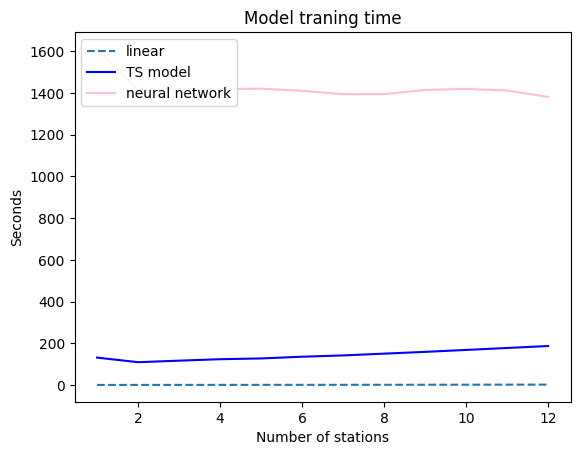

In [34]:
li_time_plot = []
fcm_time_plot = []
nn_time_plot = []
x_axis =  [1,2,3,4,5,6,7,8,9, 10, 11, 12]
for exp in training_times:
    li_time_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
    fcm_time_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
    nn_time_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_time_plot, '--', label='linear')
plt.plot(x_axis, fcm_time_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_time_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
plt.xlabel('Number of stations')
plt.ylabel('Seconds')
plt.title('Model traning time')

print(li_time_plot)
print(fcm_time_plot)
print(nn_time_plot)

Text(0.5, 1.0, 'Loss vs number of epoches')

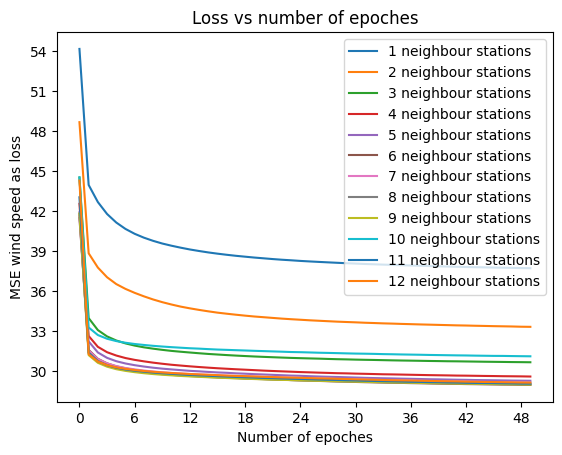

In [35]:
i = 1
fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

for exp in nn_histories:
    nn_losses = []
    for fold in exp:
        nn_losses.append(fold['loss'])
    plt.plot(np.mean(nn_losses, axis=0), label=f"{i} neighbour stations")
    i = i+1


plt.legend(loc="upper right")
#plt.ylim(5)
plt.xlabel('Number of epoches')
plt.ylabel('MSE wind speed as loss')
plt.title('Loss vs number of epoches')

In [36]:
opt_x = pd.read_csv('Data/exp/6x.csv', index_col=0)
opt_y = pd.read_csv('Data/exp/6y.csv', index_col=0)

FCM traning RMSE: 6.20895860199935
FCM traning RMSE: 6.039809208485269
FCM traning RMSE: 5.990530359381543
FCM traning RMSE: 5.967738832399078
FCM traning RMSE: 5.868589489466896
FCM traning RMSE: 5.829166988593276
FCM traning RMSE: 5.832471466494714
FCM traning RMSE: 5.850426051106057
FCM traning RMSE: 5.76274445346001
FCM traning RMSE: 5.751704677895655
FCM traning RMSE: 5.7817622727810445
FCM traning RMSE: 5.729596742867079
FCM traning RMSE: 5.722377952351467


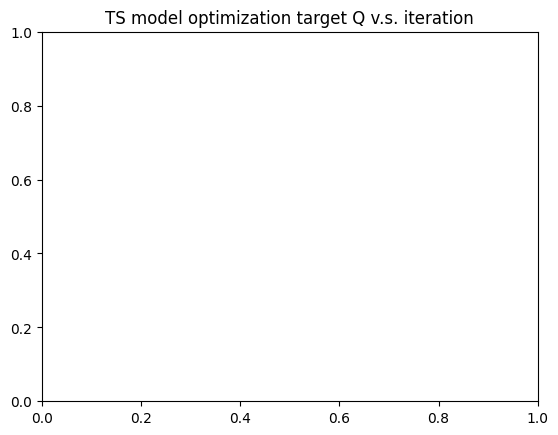

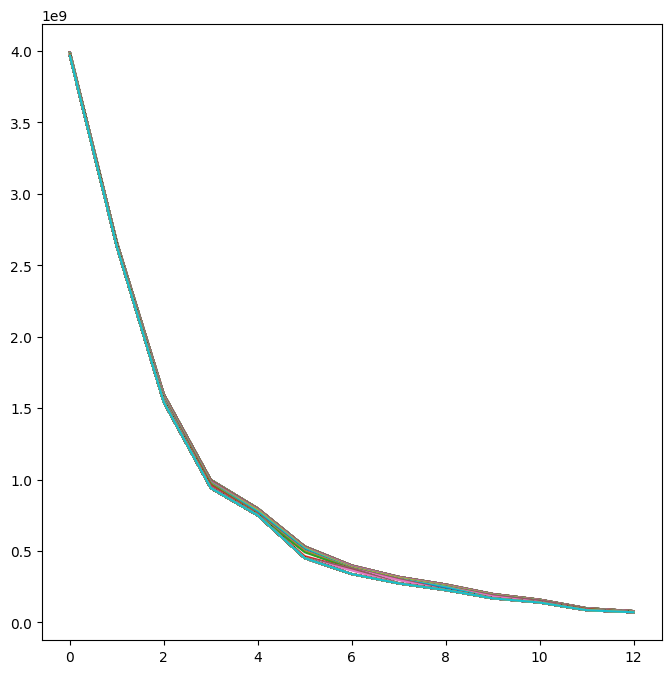

In [37]:
# Plot Q vs # of Nc
# Fcm hyperparameters
FCM_Ncs = [2,3,5,8,10,15,20,25,30,40,50,80,100]
FCM_m = 2
#tol = 1e-5
max_iter = 200
qs = []

for FCM_Nc in FCM_Ncs:   
    N = opt_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)
    temp_qs = []

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, opt_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(opt_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        q = np.sum((U ** FCM_m) * (dists ** 2))
        temp_qs.append(q)

        # 检查是否收敛
#         if np.linalg.norm(U - U_old) < tol:
#             break
    # 模型训练 find if this can be optimized
    z = np.hstack((np.ones((N, 1)), opt_x))
    H = np.zeros((N, FCM_Nc * (opt_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (opt_x.shape[1] + 1, 1)).T
        H[:, (j * (opt_x.shape[1] + 1)):((j + 1) * (opt_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(opt_y)

        
    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(opt_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(opt_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    qs.append(temp_qs)
    
plt.title('TS model optimization target Q v.s. iteration')
plt.figure(figsize=(8,8))
plt.plot(qs)

Text(0.5, 1.0, 'TS model optimization target Q v.s. iteration for differenct number of rules')

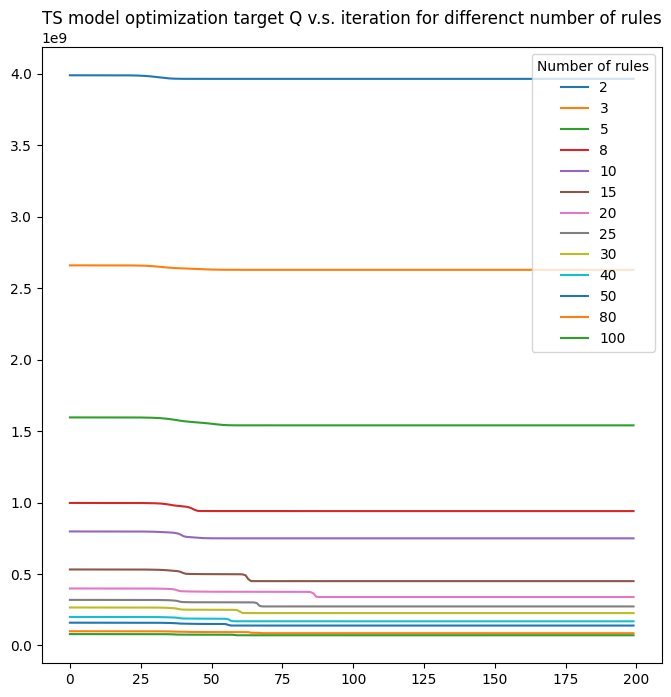

In [45]:
plt.figure(figsize=(8,8))

for exp in qs:
    plt.plot(exp)

plt.legend(FCM_Ncs, title="Number of rules")
plt.title('TS model optimization target Q v.s. iteration for differenct number of rules')